In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from zuko.utils import odeint
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm
import torchvision.transforms.functional as F
from torchvision.datasets import MNIST


In [2]:
class DoubleConv(nn.Module):
  def __init__(self,in_channels,out_channels):
    super(DoubleConv,self).__init__()
    self.convs=nn.Sequential(nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,stride=1,padding=1,bias=False)
    ,nn.BatchNorm2d(out_channels)
    ,nn.ReLU(True)
    ,nn.Conv2d(in_channels=out_channels,out_channels=out_channels,kernel_size=3,stride=1,padding=1)
    ,nn.BatchNorm2d(out_channels)
    ,nn.ReLU(True)
    ,nn.Dropout2d(0.1)
    )


  def forward(self,X):
    return self.convs(X)


class UNetGenerator(nn.Module):
  def __init__(self,input_dim,feature_list=[64,128,256,512], n_classes=0):
    super(UNetGenerator,self).__init__()
    in_channels = input_dim[0]
    out_channels = in_channels
    self.n_classes = n_classes
    self.input_dim = input_dim
    class_dim = nn.functional.one_hot(torch.zeros([1]).long(), self.n_classes).shape[-1] if n_classes != 0 else 0
    self.downward=nn.ModuleList()
    self.upward=nn.ModuleList()
    self.pool=nn.MaxPool2d(2,stride=2)
    


    ## downward path:
    for feature in feature_list:
      self.downward.append(DoubleConv(in_channels=in_channels,out_channels=feature))
      in_channels=feature


    ## upward path:
    for feature in reversed(feature_list):
      self.upward.append(nn.ConvTranspose2d(feature*2,feature,kernel_size=2,stride=2))
      self.upward.append(DoubleConv(in_channels=feature*2,out_channels=feature))

    # self.bottleneck=DoubleConv(in_channels=feature_list[-1] + 1 + class_dim,out_channels=feature_list[-1]*2)
    self.bottleneck=DoubleConv(in_channels=feature_list[-1]+1,out_channels=feature_list[-1]*2)
    tc_dim = sum(self.get_dim()[-2:])
    if tc_dim <= 2:
      tc_dim = 1
    self.time_class_encoder = nn.Linear(1+class_dim, tc_dim)
                                            
    self.output=nn.Conv2d(feature_list[0],out_channels=out_channels,kernel_size=1)
  


  def forward(self,X, t=None, y=None):
    reses=[] # skip connections
    for down in self.downward:
      X=down(X)
      reses.append(X)
      X=self.pool(X)
    

    
  
    
    t = t.to(X.dtype).reshape([-1,1])
    # X = torch.concat([X,t],dim=1)
    
    
    if self.n_classes>0:
      y = nn.functional.one_hot(y, self.n_classes).to(X.dtype).to(X.device)
      t = torch.concat([t,y], dim=1)
    t = self.time_class_encoder(t)
    

    t = t.reshape([-1,1,X.shape[-2], X.shape[-1]])
  
    
    X = torch.concat([X, t], dim=1)
    
      
    X=self.bottleneck(X)

    reses=reses[::-1]


    for i in range(0,len(self.upward),2):
      X=self.upward[i](X)
      res=reses[i//2]
      if X.shape!=res.shape:
        X=F.resize(X,size=res.shape[2:])
      cat_res=torch.cat((res,X),dim=1)
      X=self.upward[i+1](cat_res)

    return self.output(X)

  def get_dim(self):
    X = torch.randn([2] + self.input_dim)
    reses=[] # skip connections
    for down in self.downward:
      X=down(X)
      reses.append(X)
      X=self.pool(X)
    dim = X.shape
    return dim
  def odeint_function(self,t,X):
        p = next(self.parameters())
        device = p.device
        dtype = p.dtype
        t = t*torch.ones([X.shape[0],1], dtype=dtype, device=device) # preparing t for batch inference
        if self.n_classes>0:
          return self(X, t, self.y_gen)
        else:
          return self(X, t)

  def generate(self, num_samples=10000, y=None):
        p = next(self.parameters())
        device = p.device
        dtype = p.dtype
        X0 = torch.randn([num_samples] + list(self.input_dim), dtype=dtype, device=device) # initializing X0
        if self.n_classes >0:
          self.y_gen = y*torch.ones([X0.shape[0]],  device=device).long() # preparing label for batch generation
        X1 = odeint(self.odeint_function, X0, 0., 1., self.parameters()) # Solving for dphi_t(X)/dt = v_t(X)
        return X1


class OTFlowMatching(nn.Module):
    def __init__(self, sigma_min = 1e-5):
        super().__init__()
        self.sigma_min = torch.tensor(sigma_min)

    def psi_t(self, X0, X1, t):
        t = t.reshape([-1, 1, 1, 1])

        return (1 - (1 - self.sigma_min.to(X1.device)) * t) * X0 + X1 * t ## this is the psi function in the paper X(t) = psi_t(X(0), X(1))
    def forward(self, VXt, X0, X1,t):

        return nn.functional.mse_loss(VXt, (X1 - (1-self.sigma_min.to(X1.device))*X0)) # ||Vt(X(t)) - dpsi_t(X(0), X(1))/dt||


In [3]:
train_data = MNIST(root=".",download=False, train=True, transform=ToTensor(), target_transform=lambda y: torch.tensor(y).long())
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)

In [4]:
input_dim = list(train_data[0][0].shape)

In [ ]:
model = UNetGenerator(input_dim=input_dim, n_classes= len(train_data.classes)).cuda()
# model = torch.compile(model)
FMM=OTFlowMatching()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
losses = []
epochs = 100
train_loop = trange(epochs)
for epoch in train_loop:
    epoch_loss = 0
    for X1, y_tensor in tqdm(train_loader, leave=False):
        optimizer.zero_grad()

        X1 = X1.cuda()
        y_tensor = y_tensor.cuda()
        t = torch.rand(X1.shape[0], device=X1.device, dtype=X1.dtype).reshape([-1,1]) # initializing a random t
        X0 = torch.randn_like(X1, device=X1.device, dtype=X1.dtype) #initializing X0
        Xt = FMM.psi_t(X0, X1, t) # Computing Xt
        VXt = model(Xt, t, y_tensor) # forward pass
        loss = FMM(VXt, X0, X1,t)
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
    
    epoch_loss = epoch_loss/len(train_loader)
    losses.append(epoch_loss)
    scheduler.step()
    train_loop.set_postfix({"loss": epoch_loss})
plt.plot(losses)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

In [7]:
model.eval()

UNetGenerator(
  (downward): ModuleList(
    (0): DoubleConv(
      (convs): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Dropout2d(p=0.1, inplace=False)
      )
    )
    (1): DoubleConv(
      (convs): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stat

  0%|          | 0/10 [00:00<?, ?it/s]

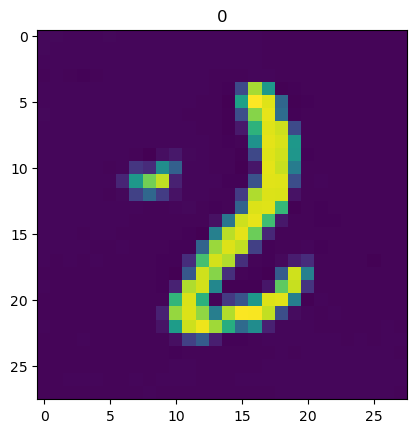

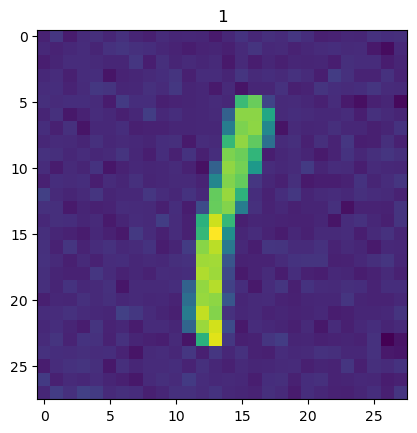

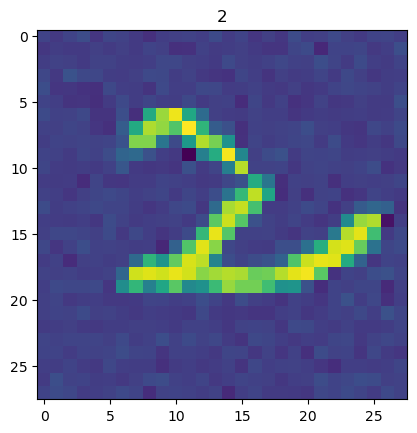

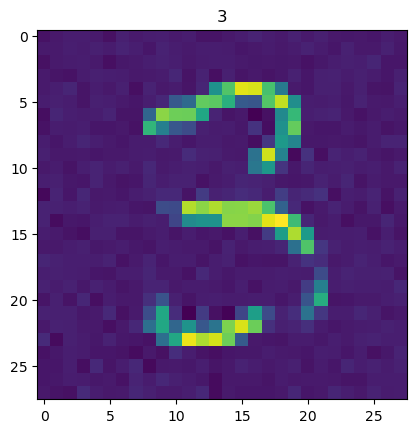

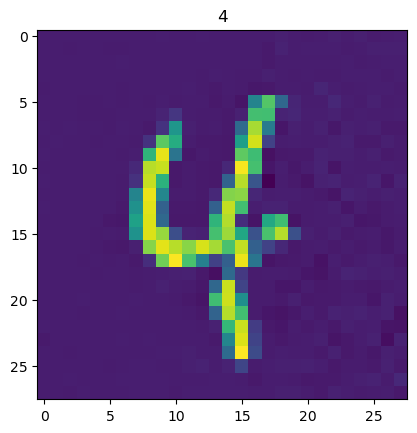

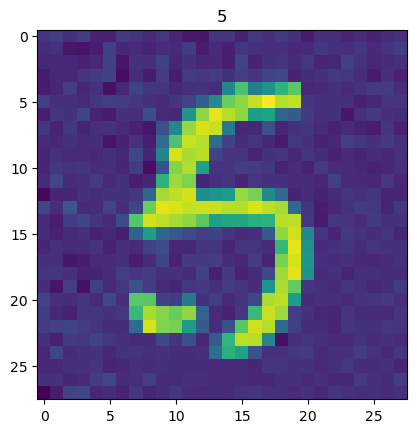

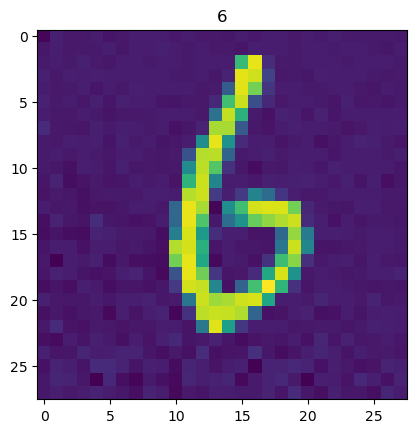

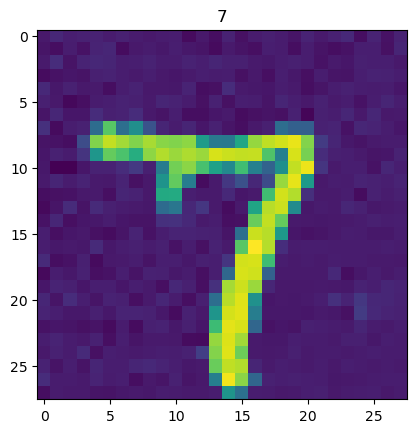

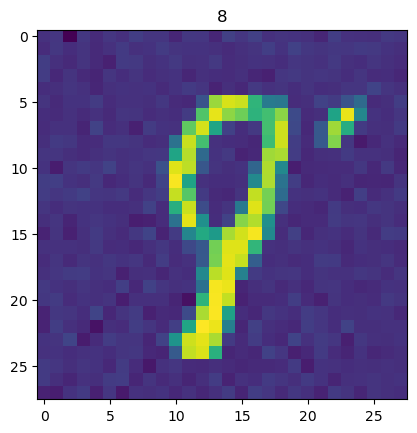

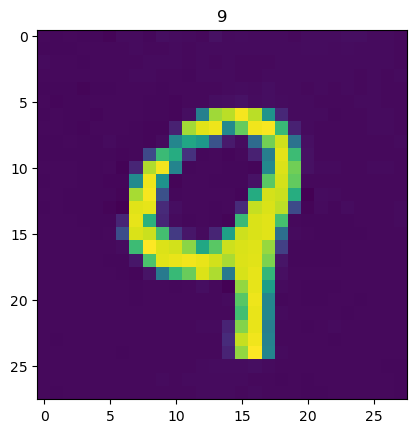

: 

In [12]:
for c in trange(10):
  X1 = model.generate(1,c)
  X1 = X1.detach().cpu().numpy()
  plt.figure()
  plt.imshow(X1.reshape(28,28))
  plt.title(c)